In [24]:
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
path = '/nfs/team283/aa16/'

In [25]:
counts = pd.read_table(path + 'KR_NAS/data/Sanger_288ROIs_TargetCountMatrix.txt')

In [26]:
np.shape(counts)

(18318, 289)

Load count data, negative probe data, metadata and properties for each ROI. We only keep genes that have more counts than the negative probe average in more than half the samples:

In [27]:
counts = pd.read_table(path + 'KR_NAS/data/Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')

metadata = pd.read_csv(path + 'KR_NAS/data/NanoString sequencing all annotations 2020.02.10.csv')
metadata = metadata.iloc[0:286,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
metadata = metadata.drop(labels='Sample_ID', axis = 1)
metadata = metadata.drop(labels='nuclei', axis = 1)

properties = pd.read_table(path + 'KR_NAS/data/Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['Sample_ID'])
properties = properties.reindex(np.array(metadata.index))
properties = properties.drop(labels='Sample_ID', axis = 1)

negProbes = pd.read_csv(path + 'KR_NAS/data/Sanger_dedup_withNegProbes.csv')
negProbes = negProbes.loc[negProbes.iloc[:,0] == 'NegProbe-WTX',]
genes = negProbes['Unnamed: 0']
negProbes = negProbes.drop('Unnamed: 0',1)
negProbes = negProbes.rename(index=genes)
negProbes = negProbes.astype('int')
negProbes = negProbes[counts.keys()]

#mean_negProbes = np.array(np.mean(negProbes))
#boolean = np.sum(np.asarray([counts.iloc[:,i] > mean_negProbes[i] for i in range(len(mean_negProbes))]), axis = 0) > np.shape(counts)[1]*0.55
#counts = counts.loc[boolean,:]

counts = pd.concat((counts, negProbes), axis = 0)

Put it into an anndata object:

In [28]:
adata = sc.AnnData(X=np.array(counts).T, obs=pd.concat((metadata, properties), axis = 1), var=np.array(counts.index))
adata.var_names = counts.index

Check for ROIs with very few reads:

Text(0, 0.5, 'Number of Reads')

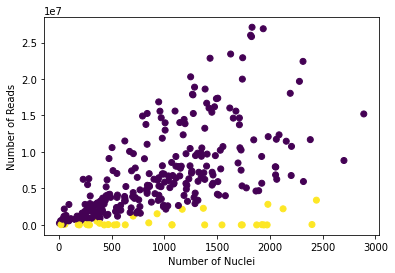

In [29]:
cutoff = 2000
reads_per_nuclei = adata.obs['AlignedReads']/adata.obs['nuclei']
plt.show()
plt.scatter(adata.obs['nuclei'], adata.obs['AlignedReads'],
           c = reads_per_nuclei < cutoff)
plt.xlabel('Number of Nuclei')
plt.ylabel('Number of Reads')

In [33]:
reads_per_nuclei

HCA_F_BRA8739081     1442.119444
HCA_F_BRA8739082    11648.234375
HCA_F_BRA8739083     6830.875396
HCA_F_BRA8739084     6910.600000
HCA_F_BRA8739085     6122.504075
                        ...     
HCA_F_BRA8739364        0.582933
HCA_F_BRA8739365        1.099540
HCA_F_BRA8739366        0.460543
HCA_F_BRA8739367        0.101793
HCA_F_BRA8739368        0.019043
Length: 288, dtype: float64

Mark ROIs with less than 500 reads per nuclei as low quality:

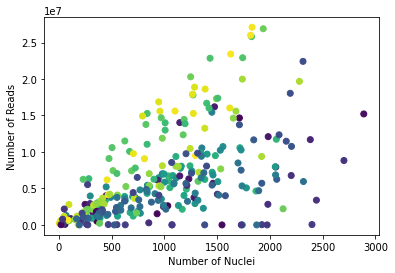

In [35]:
import matplotlib.pyplot as plt
plt.show()
plt.scatter(adata.obs['nuclei'], adata.obs['AlignedReads'],
           c = adata.obs['ORDER'])
plt.xlabel('Number of Nuclei')
plt.ylabel('Number of Reads')
adata.obs['GoodQuality'] = reads_per_nuclei > cutoff

Add some normalizations to the object:

In [8]:
adata.obs['TotalCounts'] = np.sum(adata.X, axis = 1)
adata.layers['CPM'] = np.asarray([adata.X[i,:]/adata.obs['TotalCounts'][i] for i in range(len(adata.obs['TotalCounts']))])*10**6

Remove outlier genes with very hight counts:

In [9]:
counts_mean = np.mean(adata.X, axis = 0)
subset = np.array([abs(counts_mean - np.mean(counts_mean)) < 3 * np.std(counts_mean)]).flatten()
print(np.shape(adata))
adata = adata[:,subset]
print(np.shape(adata))

(288, 18454)
(288, 18416)


Save:

In [10]:
adata.obs.index = range(len(adata.obs.index))

In [11]:
adata.var.index = range(len(adata.var.index))

In [12]:
adata.var_names = np.array(adata.var).flatten()

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
adata.var['SYMBOL'] = np.array(adata.var).flatten()

In [14]:
adata.var = adata.var.drop(0, axis = 1)

In [15]:
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()]

In [16]:
adata.obs.index = [str(x) for x in adata.obs.index]

In [17]:
pickle.dump(adata, open("/nfs/team283/aa16/InSituCellTools/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))

In [18]:
pickle.dump(adata, open("/nfs/team283/aa16/KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))

In [19]:
adata.write_h5ad('/nfs/team283/aa16/KR_NAS/data/test.h5ad')

... storing 'panel' as categorical
... storing 'construct' as categorical
... storing 'instrument_type' as categorical
... storing 'read_pattern' as categorical
... storing 'ngs_prep' as categorical
... storing 'pcr_primer_plate' as categorical
... storing 'pcr_primer_well' as categorical
... storing 'Index 1' as categorical
... storing 'Barcode 1' as categorical
... storing 'Index 2' as categorical
... storing '\tBarcode 2' as categorical
... storing 'segment_type' as categorical
... storing 'segment' as categorical
... storing 'aoi' as categorical
... storing 'dsp_date' as categorical
... storing 'dsp_well' as categorical
... storing 'slide' as categorical
... storing 'human_sample_ID' as categorical
... storing 'slide_barcode' as categorical
... storing 'age' as categorical
... storing 'source_ID' as categorical
... storing 'Sanger_sampleID' as categorical
... storing 'AOI_type' as categorical
... storing 'Region' as categorical
... storing 'Plate' as categorical
... storing 'SYMBOL

In [17]:
subset = [adata.obs['slide'].iloc[i] == '00MU' and
         adata.obs['Radial_position'].iloc[i] == 2 for i in range(len(adata.obs['Radial_position']))]

In [19]:
adata_small = adata[subset,:]

In [23]:
pickle.dump(adata_small, open("/nfs/team283/aa16/KR_NAS/data/nanostringWTA_fetailBrain_AnnData_smallestExample.p", "wb" ))